Linux shows inverted Eigenfaces, if path list is loaded via glob.
Sorted list gives correct results!


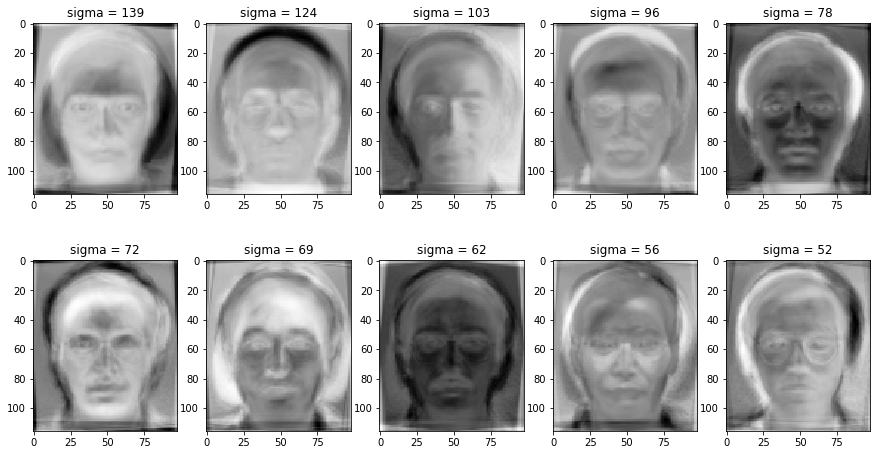

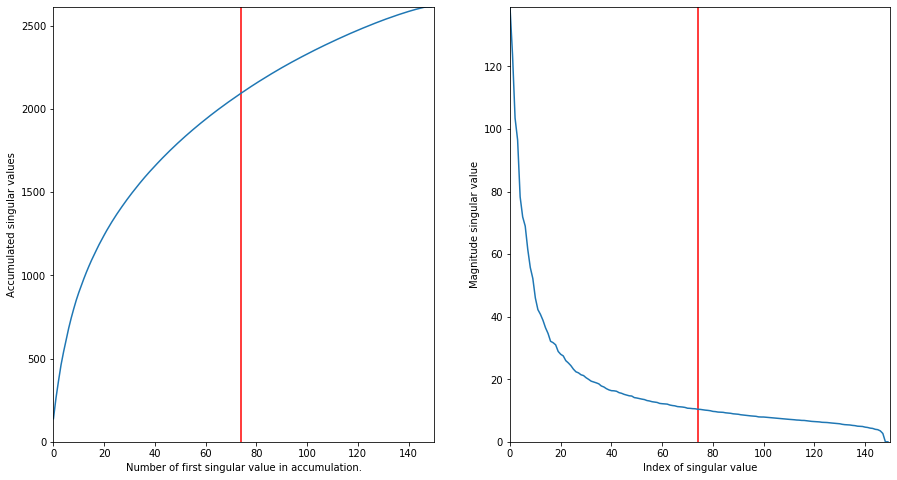

Linux shows inverted Eigenfaces, if path list is loaded via glob.
Sorted list gives correct results!


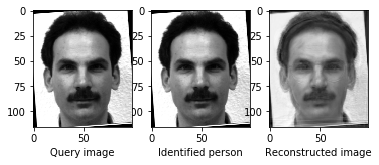

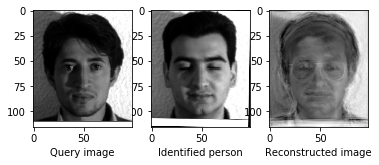

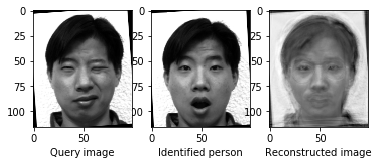

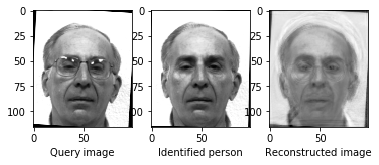

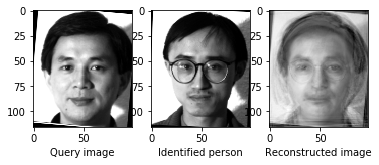

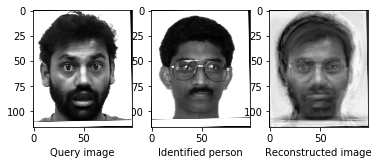

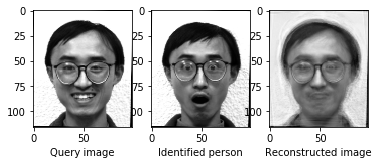

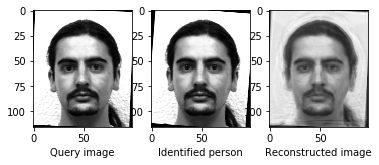

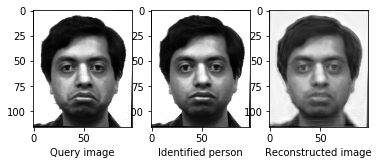

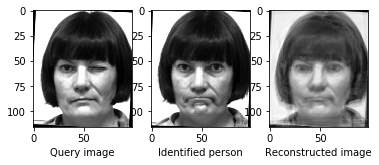

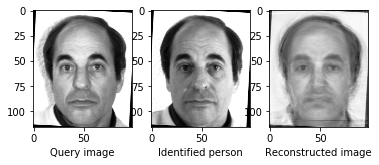

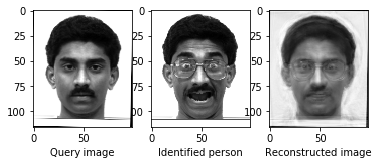

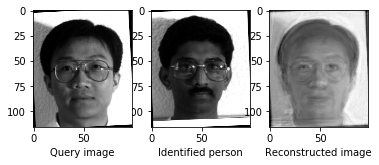

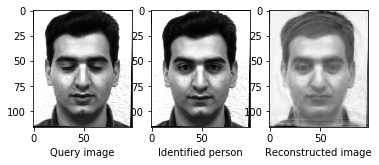

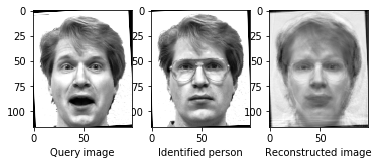

In [1]:
import numpy as np
#import lib
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimage

# show plot first run
%matplotlib inline 
# test autocompletion with tab or tab+shift
%config IPCompleter.greedy=True 

####################################################################################################


def load_images(path: str) -> list:
    """
    Load all images in path

    :param path: path of directory containing image files

    :return images: list of images (each image as numpy.ndarray and dtype=float64)
    """
    # 1.1 Laden Sie für jedes Bild in dem Ordner das Bild als numpy.array und
    # speichern Sie es in einer "Datenbank" eine Liste.
    # Tipp: Mit glob.glob("data/train/*") bekommen Sie eine Liste mit allen
    # Dateien in dem angegebenen Verzeichnis.
    images = []
    
    img_list = glob.glob(path)
    #print('pre:',img_list)
    print('Linux shows inverted Eigenfaces, if path list is loaded via glob.')
    print('Sorted list gives correct results!')
    img_list = np.sort(img_list)
    #print('pre:',img_list)
    
    for i in range(len(img_list)):
    #for i in range(len(img_list)-1,-1,-1):
        image = mpl.image.imread(img_list[i])
        img_mtx = np.asarray(image, dtype="float64")
        images.append(img_mtx)
    
    # 1.2 Geben Sie die Liste zurück
    return images


def setup_data_matrix(images: list) -> np.ndarray:
    """
    Create data matrix out of list of 2D data sets.

    :param images: list of 2D images (assumed to be all homogeneous of the same size and type np.ndarray)

    :return D: data matrix that contains the flattened images as rows
    """
    # 2.1 Initalisiere die Datenmatrix mit der richtigen Größe und Typ.
    # Achtung! Welche Dimension hat die Matrix?
    
    # setup data matrix
    D = np.zeros((len(images), images[0].size), dtype=images[0].dtype)

    # 2.2 Fügen Sie die Bilder als Zeilen in die Matrix ein.
    for i in range(len(images)):
        D[i, :] = images[i].flatten()
    
    # 2.3 Geben Sie die Matrix zurück
    return D

def calculate_svd(D: np.ndarray) -> (np.ndarray, np.ndarray, np.ndarray):
    """
    Perform SVD analysis for given data matrix.

    :param D: data matrix of size n x m where n is the number of observations and m the number of variables

    :return eigenvec: matrix containing principal components as rows
    :return singular_values: singular values associated with eigenvectors
    :return mean_data: mean that was subtracted from data
    """

    # 3.1 Berechnen Sie den Mittelpukt der Daten
    # Tipp: Dies ist in einer Zeile möglich (np.mean, besitzt ein Argument names axis)
    Dmean = np.mean(D,axis=0)
    D -= Dmean

    # 3.2 Berechnen Sie die Hauptkomponeten sowie die Singulärwerte der ZENTRIERTEN Daten.
    # Dazu können Sie numpy.linalg.svd(..., full_matrices=False) nutzen.
    U, S, VT = np.linalg.svd(D, full_matrices=False)
        
    # 3.3 Geben Sie die Hauptkomponenten, die Singulärwerte sowie den Mittelpunkt der Daten zurück
    return VT, S, Dmean

def accumulated_energy(singular_values: np.ndarray, threshold: float = 0.8) -> int:
    """
    Compute index k so that threshold percent of magnitude of singular values is contained in
    first k singular vectors.

    :param singular_values: vector containing singular values
    :param threshold: threshold for determining k (default = 0.8)

    :return k: threshold index
    """
 
    # 4.1 Normalizieren Sie die Singulärwerte d.h. die Summe aller Singlärwerte soll 1 sein
    sing_norm = singular_values / (np.sum(singular_values) + 1e-16)

    # 4.2 Finden Sie den index k, sodass die ersten k Singulärwerte >= dem Threshold sind.
    singsum = 0
    for k in range(len(sing_norm)):
        singsum += sing_norm[k]
        if singsum > threshold:
            break
    
    # 4.3 Geben Sie k zurück
    return k


def project_faces(pcs: np.ndarray, mean_data: np.ndarray, images: list) -> np.ndarray:
    """
    Project given image set into basis.

    :param pcs: matrix containing principal components / eigenfunctions as rows
    :param images: original input images from which pcs were created
    :param mean_data: mean data that was subtracted before computation of SVD/PCA

    :return coefficients: basis function coefficients for input images, each row contains coefficients of one image
    """
    # 5.1 Initialisieren Sie die Koeffizienten für die Basis.
    # Sie sollen als Zeilen in einem np.array gespeichert werden.
    images -= mean_data

    # 5.1 Berechnen Sie für jedes Bild die Koeffizienten.
    # Achtung! Denkt daran, dass die Daten zentriert werden müssen.
    coeff = images @ pcs.T
    
    # 5.2 Geben Sie die Koeffizenten zurück
    return coeff


def identify_faces(coeffs_train: np.ndarray, coeffs_test: np.ndarray) -> (
np.ndarray):
    """
    Perform face recognition for test images assumed to contain faces.

    For each image coefficients in the test data set the closest match in the training data set is calculated.
    The distance between images is given by the angle between their coefficient vectors.

    :param coeffs_train: coefficients for training images, each image is represented in a row
    :param coeffs_test: coefficients for test images, each image is represented in a row

    :return indices: array containing the indices of the found matches
    """
    # 8.1 Berechnen Sie für jeden Testvektor den nächsten Trainingsvektor.
    # Achtung! Die Distanzfunktion ist definiert über den Winkel zwischen den Vektoren.
    matches = np.zeros(coeffs_test.shape[0],dtype=int)
    
    angle = 0
    for i in range(coeffs_test.shape[0]):
        tmp1 = 0
        tmp2 = 100000
        for j in range(coeffs_train.shape[0]):
            c = np.dot(coeffs_test[i,:],coeffs_train[j,:])/(np.linalg.norm(coeffs_test[i,:])*np.linalg.norm(coeffs_train[j,:]))
            tmp1 = np.arccos(np.clip(c, -1, 1))
            #print('test:',i,j,tmp1)
            if tmp1<tmp2:
                tmp2=tmp1
                matches[i] = j
                #print('sel:',i,j,tmp2)
    
    
    return matches

if __name__ == '__main__':

    # 1. Aufgabe: Laden Sie die Trainingsbilder.
    # Implementieren Sie dazu die Funktion load_images.
    images = load_images('./data/train/*')
    
    # 2. Aufgabe: Konvertieren Sie die Bilder zu Vektoren die Sie alle übereinander speichern,
    # sodass sich eine n x m Matrix ergibt (dabei ist n die Anzahl der Bilder und m die Länge des Bildvektors).
    # Implementieren Sie dazu die Funktion setup_data_matrix.
    data = setup_data_matrix(images)
    
    # 3. Aufgabe: Finden Sie alle Hauptkomponeten des Datensatztes.
    # Implementieren Sie dazu die Funktion calculate_svd
    pcs, S, Dmean = calculate_svd(data)
    
    #n: number of eigenfaces to draw
    #pcs: principal component matrix whose rows are the eigenfaces
    #sv: singular values vector
    #dim_x: x_dimension of the original images
    #dim_y: y_dimension of the original images
    lib.visualize_eigenfaces(10, pcs, S, images[0].shape[1],images[0].shape[0])
    
    # 4. Aufgabe: Entfernen Sie die "unwichtigsten" Basisvektoren.
    # Implementieren Sie dazu die Funktion accumulated_energy um zu wissen wie viele
    # Baisvektoren behalten werden sollen. Plotten Sie Ihr Ergebnis mittels
    # lib.plot_singular_values_and_energy
    thresh = 0.8
    k = accumulated_energy(S,thresh)
    
    #print(k)
    lib.plot_singular_values_and_energy(S,k)
    
    # 5. Aufgabe: Projizieren Sie die Trainingsdaten in den gefundenen k-dimensionalen Raum,
    # indem Sie die Koeffizienten für die gefundene Basis finden.
    # Implementieren Sie dazu die Funktion project_faces
    coeffs_train = project_faces(pcs[:k,:], Dmean, data)
    
    # 6. Aufgabe: Laden Sie die Test Bilder (load_images).
    img_test = load_images('./data/test/*')
    data_test = setup_data_matrix(img_test)
    
    # 7. Aufgabe: Projizieren Sie die Testbilder in den gefundenen k-dimensionalen Raum (project_faces).
    coeffs_test = project_faces(pcs[:k,:], Dmean, data_test)
    #print('coeff:',coeff.shape)
    
    # 8. Aufgabe: Berechnen Sie für jedes Testbild das nächste Trainingsbild in dem
    # gefundenen k-dimensionalen Raum. Die Distanzfunktion ist über den Winkel zwischen den Punkten definiert.
    # Implementieren Sie dazu die Funktion identify_faces.
    # Plotten Sie ihr Ergebnis mit der Funktion lib.plot_identified_faces
    matches = identify_faces(coeffs_train, coeffs_test)
    #print(matches)
    
    # plot the identified faces
    lib.plot_identified_faces(matches, images, img_test, pcs[:k,:], coeffs_test, Dmean)